TESTING 2-MODEL ENSEMBLE (Inception-SE + sEMG-Net)

Loading Dataset configuration...
Found 440 test files.
Loading raw data...
Preprocessing...
Data Ready. Shape: (13200, 204, 8)

RUNNING ENSEMBLE INFERENCE
Loading inception_se...
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step
   -> inception_se Standalone Acc: 0.8238
Loading semg_net...
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
   -> semg_net Standalone Acc: 0.8313

FINAL ENSEMBLE RESULTS
ACCURACY: 0.8455
F1 SCORE: 0.8460
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      2640
           1       0.79      0.82      0.80      2640
           2       0.79      0.78      0.78      2640
           3       0.81      0.80      0.80      2640
           4       0.98      0.93      0.95      2640

    accuracy                           0.85     13200
   macro avg       0.85      0.85      0.85     13200
weighted avg       0.85      0.85      0.85     13200


Generating Hackathon Visualizations..

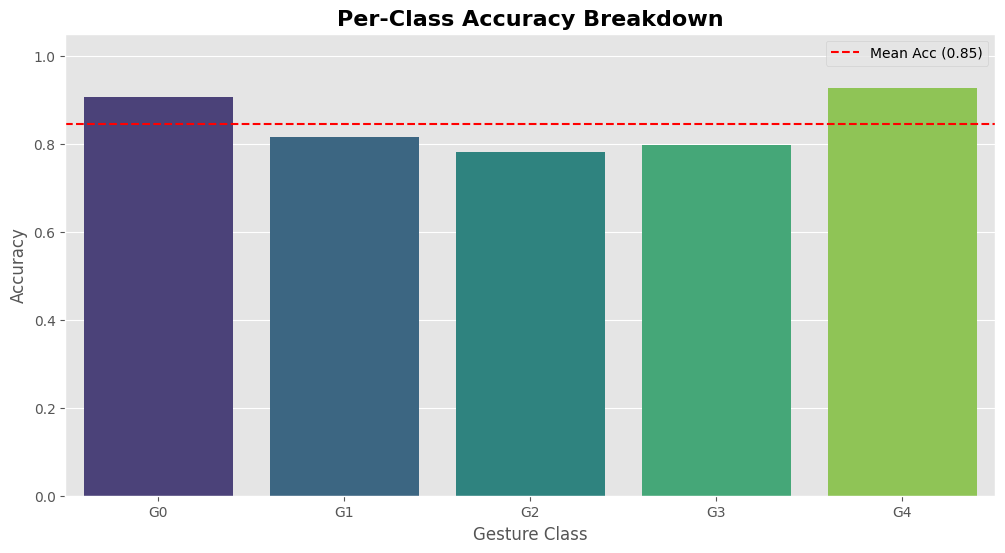

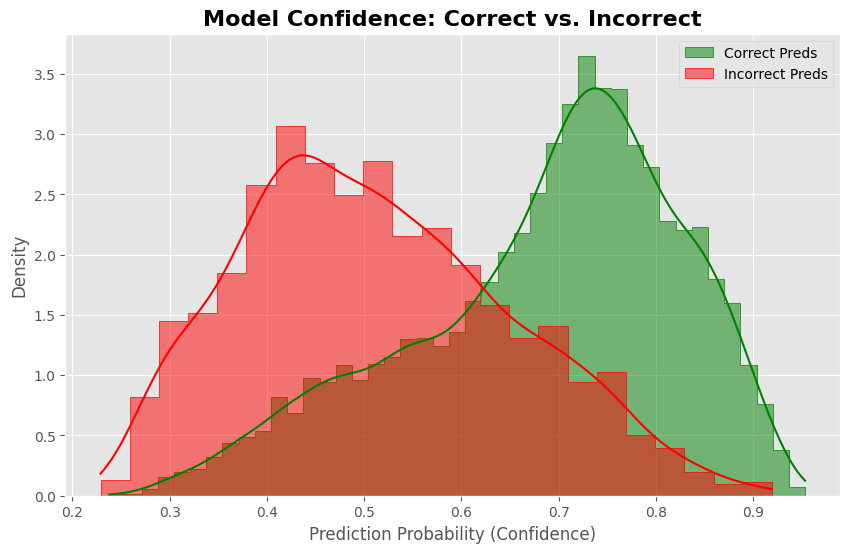

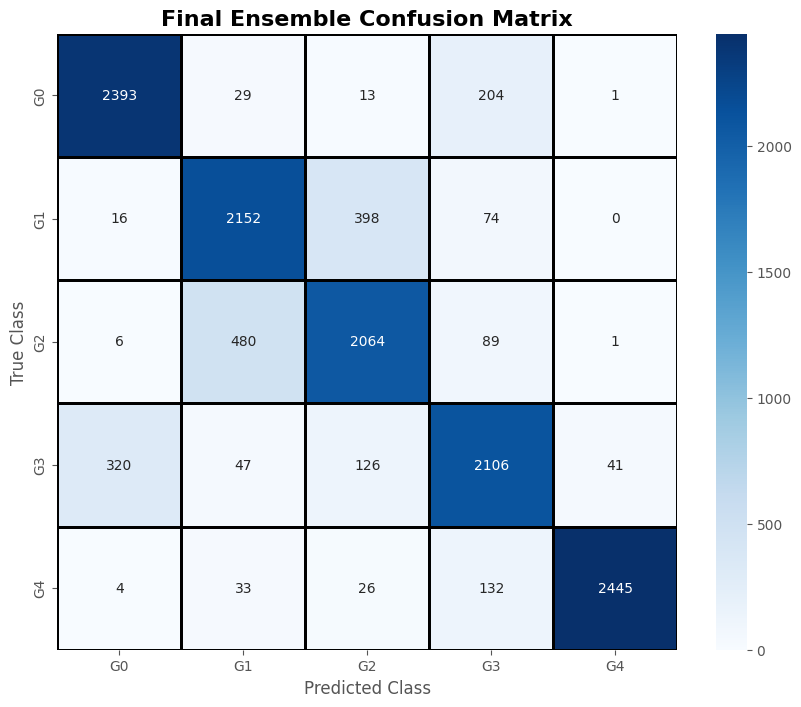

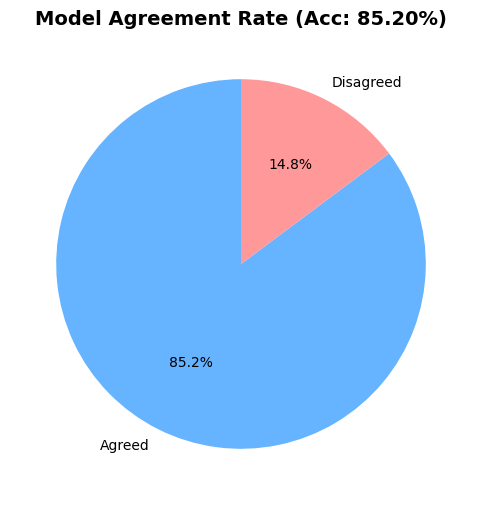

In [15]:
#!/usr/bin/env python3
"""
FINAL TEST SCRIPT: 2-MODEL ENSEMBLE + HACKATHON VISUALIZATIONS
-----------------------------------------------------------------
Evaluates the Inception-SE + sEMG-Net ensemble.
Generates high-impact charts for hackathon presentations.
"""

import os
import glob
import re
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from scipy.stats import mode
from scipy.signal import butter, filtfilt, iirnotch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ==================== CONFIGURATION ====================
DATA_DIR = 'data'
ARTIFACTS_DIR = 'artifacts_final'
FS = 512
WINDOW_MS = 400
STRIDE_MS = 160
BATCH_SIZE = 128
L2_REG = 1e-4

# Ensure artifacts directory exists
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# Set style for plots
plt.style.use('ggplot')
sns.set_palette("viridis")

# ==================== ARCHITECTURES ====================

def squeeze_excite_block(input_tensor, ratio=8):
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling1D()(input_tensor)
    se = layers.Dense(filters // ratio, activation='relu', kernel_regularizer=regularizers.l2(L2_REG))(se)
    se = layers.Dense(filters, activation='sigmoid', kernel_regularizer=regularizers.l2(L2_REG))(se)
    se = layers.Reshape((1, filters))(se)
    return layers.Multiply()([input_tensor, se])

def inception_block(x, filters, dilation_rate):
    b1 = layers.Conv1D(filters=filters//2, kernel_size=3, dilation_rate=dilation_rate,
                       padding='same', kernel_regularizer=regularizers.l2(L2_REG))(x)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.Activation('relu')(b1)
    b2 = layers.Conv1D(filters=filters//2, kernel_size=7, dilation_rate=dilation_rate,
                       padding='same', kernel_regularizer=regularizers.l2(L2_REG))(x)
    b2 = layers.BatchNormalization()(b2)
    b2 = layers.Activation('relu')(b2)
    return layers.Concatenate()([b1, b2])

def make_inception_se_tcn(input_shape, n_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.GaussianNoise(0.05)(inputs)
    filters = 64
    for dilation_rate in [1, 2, 4, 8]:
        prev_x = x
        x = inception_block(x, filters, dilation_rate)
        x = layers.Dropout(0.2)(x)
        x = squeeze_excite_block(x, ratio=8)
        if prev_x.shape[-1] != filters:
            prev_x = layers.Conv1D(filters=filters, kernel_size=1, padding='same')(prev_x)
        x = layers.Add()([x, prev_x])

    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.MultiHeadAttention(key_dim=64, num_heads=4, dropout=0.3)(x, x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(L2_REG))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(n_classes, activation='softmax', dtype='float32')(x)
    return keras.Model(inputs, outputs, name='Inception_SE_Attn')

def conv_block(x, filters, kernel_size, pool=True):
    x = layers.Conv1D(filters, kernel_size, padding='same', kernel_regularizer=regularizers.l2(L2_REG))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.25)(x)
    if pool: x = layers.MaxPooling1D(pool_size=2)(x)
    return x

def make_semg_net(input_shape, n_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.GaussianNoise(0.05)(inputs)
    x = conv_block(x, 64, 9, pool=False)
    x = conv_block(x, 128, 5, pool=True)
    x = conv_block(x, 256, 3, pool=True)
    x = conv_block(x, 512, 3, pool=True)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(L2_REG))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(n_classes, activation='softmax', dtype='float32')(x)
    return keras.Model(inputs, outputs, name='sEMG_Net')

# ==================== DATA UTILS ====================

class SignalPreprocessor:
    def __init__(self, fs=1000, bandpass_low=20.0, bandpass_high=450.0, notch_freq=50.0):
        self.fs = fs
        self.nyq = fs / 2
        low = max(0.001, min(bandpass_low / self.nyq, 0.99))
        high = max(low + 0.01, min(bandpass_high / self.nyq, 0.999))
        self.b_bp, self.a_bp = butter(4, [low, high], btype='band')
        self.b_notch, self.a_notch = iirnotch(notch_freq, 30.0, self.fs) if notch_freq > 0 else (None, None)
        self.channel_means, self.channel_stds = None, None
        self.fitted = False

    def fit(self, signals_list):
        all_signals = np.concatenate(signals_list, axis=0)
        self.channel_means = np.mean(all_signals, axis=0)
        self.channel_stds = np.std(all_signals, axis=0) + 1e-8
        self.fitted = True
        return self

    def transform(self, signal):
        if len(signal) > 12:
            signal = filtfilt(self.b_bp, self.a_bp, signal, axis=0)
            if self.b_notch is not None:
                signal = filtfilt(self.b_notch, self.a_notch, signal, axis=0)
        if self.fitted:
            return (signal - self.channel_means) / self.channel_stds
        return (signal - np.mean(signal, axis=0)) / (np.std(signal, axis=0) + 1e-8)

    def segment(self, signal, window_ms=200, stride_ms=100):
        win_sz = int(window_ms * self.fs / 1000)
        step = int(stride_ms * self.fs / 1000)
        n = len(signal)
        if n < win_sz: return None
        n_win = (n - win_sz) // step + 1
        idx = np.arange(win_sz)[None, :] + np.arange(n_win)[:, None] * step
        return signal[idx]

def get_session_files(data_dir, sessions):
    files = []
    for session in sessions:
        pattern = f'{data_dir}/**/{session}/**/*.csv'
        files.extend(sorted(glob.glob(pattern, recursive=True)))
    return files

def load_files_data(file_list):
    data_list, labels_list = [], []
    for f in file_list:
        try:
            lbl = int(re.search(r'gesture(\d+)', f).group(1))
            d = pd.read_csv(f).values
            if d.shape[1] >= 8:
                data_list.append(d)
                labels_list.append(np.full(len(d), lbl))
        except: pass
    return data_list, labels_list

def window_data(data_list, labels_list, prep, window_ms, stride_ms):
    X_wins, y_wins = [], []
    win_sz = int(window_ms * FS / 1000)
    step = int(stride_ms * FS / 1000)
    for d, l in zip(data_list, labels_list):
        d_filt = prep.transform(d)
        w = prep.segment(d_filt, window_ms, stride_ms)
        if w is not None:
            X_wins.append(w)
            n_win = (len(d) - win_sz) // step + 1
            idx = np.arange(win_sz)[None, :] + np.arange(n_win)[:, None] * step
            w_modes = mode(l[idx], axis=1, keepdims=True)[0].flatten()
            y_wins.append(w_modes)
    if not X_wins: return None, None
    return np.concatenate(X_wins), np.concatenate(y_wins)

# ==================== VISUALIZATIONS ====================

def generate_hackathon_visualizations(y_true, y_pred, ensemble_probs, class_names):
    """
    Generates 3 additional high-impact plots for presentation.
    """
    print("\nGenerating Hackathon Visualizations...")

    # 1. PER-CLASS ACCURACY BAR PLOT
    plt.figure(figsize=(12, 6))
    cm = confusion_matrix(y_true, y_pred)
    # Calculate accuracy per class: diag / row_sum
    class_acc = cm.diagonal() / cm.sum(axis=1)

    sns.barplot(x=class_names, y=class_acc, palette="viridis")
    plt.axhline(y=np.mean(class_acc), color='r', linestyle='--', label=f'Mean Acc ({np.mean(class_acc):.2f})')
    plt.title("Per-Class Accuracy Breakdown", fontsize=16, fontweight='bold')
    plt.ylabel("Accuracy")
    plt.xlabel("Gesture Class")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.savefig(f'{ARTIFACTS_DIR}/viz_class_accuracy.png', bbox_inches='tight')
    print(f"   -> Saved: {ARTIFACTS_DIR}/viz_class_accuracy.png")

    # 2. CONFIDENCE DISTRIBUTION (Correct vs Incorrect)
    max_probs = np.max(ensemble_probs, axis=1)
    correct_mask = (y_true == y_pred)

    plt.figure(figsize=(10, 6))
    sns.histplot(max_probs[correct_mask], color="green", label="Correct Preds", kde=True, stat="density", element="step", alpha=0.5)
    sns.histplot(max_probs[~correct_mask], color="red", label="Incorrect Preds", kde=True, stat="density", element="step", alpha=0.5)
    plt.title("Model Confidence: Correct vs. Incorrect", fontsize=16, fontweight='bold')
    plt.xlabel("Prediction Probability (Confidence)")
    plt.ylabel("Density")
    plt.legend()
    plt.savefig(f'{ARTIFACTS_DIR}/viz_confidence_dist.png', bbox_inches='tight')
    print(f"   -> Saved: {ARTIFACTS_DIR}/viz_confidence_dist.png")

    # 3. CONFUSION HEATMAP (Polished)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, linewidths=1, linecolor='black')
    plt.title('Final Ensemble Confusion Matrix', fontsize=16, fontweight='bold')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.savefig(f'{ARTIFACTS_DIR}/viz_confusion_matrix.png', bbox_inches='tight')
    print(f"   -> Saved: {ARTIFACTS_DIR}/viz_confusion_matrix.png")

def plot_model_agreement(preds_a, preds_b, y_true):
    """
    Scatter plot to see how much the two models agree.
    """
    # Get the predicted class indices
    pred_class_a = np.argmax(preds_a, axis=1)
    pred_class_b = np.argmax(preds_b, axis=1)

    agreement = (pred_class_a == pred_class_b)
    accuracy_agreement = np.mean(agreement)

    # Simple pie chart of agreement
    plt.figure(figsize=(6, 6))
    plt.pie([np.sum(agreement), np.sum(~agreement)], labels=['Agreed', 'Disagreed'],
            autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'], startangle=90)
    plt.title(f'Model Agreement Rate (Acc: {accuracy_agreement:.2%})', fontsize=14, fontweight='bold')
    plt.savefig(f'{ARTIFACTS_DIR}/viz_model_agreement.png', bbox_inches='tight')
    print(f"   -> Saved: {ARTIFACTS_DIR}/viz_model_agreement.png")

# ==================== MAIN ====================

def main():
    print("TESTING 2-MODEL ENSEMBLE (Inception-SE + sEMG-Net)")

    # 1. SETUP DATA (Split Reproduction)
    print("\nLoading Dataset configuration...")
    train_files = get_session_files(DATA_DIR, ['Session1', 'Session2'])
    session3_files = get_session_files(DATA_DIR, ['Session3'])

    # Reproduce the random split used in training
    gesture_files = {}
    for f in session3_files:
        match = re.search(r'gesture(\d+)', f)
        if match:
            g = int(match.group(1))
            gesture_files.setdefault(g, []).append(f)

    test_files_final = []
    rng = random.Random(42) # Match seed from training

    for g, gfiles in gesture_files.items():
        rng.shuffle(gfiles)
        # Training logic: val_files = [:n_val], test_files = [n_val:]
        n_val = max(1, int(len(gfiles) * 0.50))
        test_files_final.extend(gfiles[n_val:])

    print(f"Found {len(test_files_final)} test files.")

    # 2. LOAD & PREPROCESS
    print("Loading raw data...")
    train_data_raw, train_labels_raw = load_files_data(train_files)
    test_data_raw, test_labels_raw = load_files_data(test_files_final)

    print("Preprocessing...")
    prep = SignalPreprocessor(fs=FS)
    prep.fit(train_data_raw)

    X_test, y_test_raw = window_data(test_data_raw, test_labels_raw, prep, WINDOW_MS, STRIDE_MS)

    # 3. LABEL ENCODING
    _, y_train_raw_dummy = window_data(train_data_raw, train_labels_raw, prep, WINDOW_MS, STRIDE_MS)
    le = LabelEncoder().fit(y_train_raw_dummy)
    y_test = np.array([le.transform([l])[0] if l in le.classes_ else -1 for l in y_test_raw])
    n_classes = len(le.classes_)
    input_shape = X_test.shape[1:]
    class_names = [f"G{c}" for c in le.classes_] # Short names for plots

    print(f"Data Ready. Shape: {X_test.shape}")

    # 4. LOAD MODELS
    print("\nRUNNING ENSEMBLE INFERENCE")

    models_config = [
        ("inception_se", make_inception_se_tcn),
        ("semg_net", make_semg_net)
    ]

    predictions = []

    for name, builder in models_config:
        path = f'{ARTIFACTS_DIR}/best_{name}.keras'
        if not os.path.exists(path):
            print(f"Error: Could not find {path}")
            continue

        print(f"Loading {name}...")
        model = builder(input_shape, n_classes)
        model.load_weights(path)

        probs = model.predict(X_test, batch_size=BATCH_SIZE, verbose=1)
        predictions.append(probs)

        # Individual Check
        acc = accuracy_score(y_test, probs.argmax(axis=1))
        print(f"   -> {name} Standalone Acc: {acc:.4f}")
        tf.keras.backend.clear_session()

    # 5. SOFT VOTING & VISUALIZATION
    if len(predictions) == 2:
        ensemble_probs = (predictions[0] + predictions[1]) / 2.0
        final_preds = ensemble_probs.argmax(axis=1)

        acc = accuracy_score(y_test, final_preds)
        f1 = f1_score(y_test, final_preds, average='macro')

        print("\nFINAL ENSEMBLE RESULTS")
        print(f"ACCURACY: {acc:.4f}")
        print(f"F1 SCORE: {f1:.4f}")

        print(classification_report(y_test, final_preds, target_names=[str(c) for c in le.classes_]))

        # --- HACKATHON VIZ CALLS ---
        generate_hackathon_visualizations(y_test, final_preds, ensemble_probs, class_names)
        plot_model_agreement(predictions[0], predictions[1], y_test)

        print("\nDONE! Check the 'artifacts_final' folder for your plots.")

    else:
        print("Error: Not enough models loaded for ensemble.")

if __name__ == "__main__":
    main()